## 1. Importing Libs / Data loading / Environment setting

In [1]:
# basic lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msn
import warnings
import random
import math

# setting
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 20)

In [2]:
from sklearn.model_selection import train_test_split
import re

import torch

# reproducibility (global setting)
torch.manual_seed(12)
np.random.seed(12)
random.seed(12)

import pkg_resources
from symspellpy import SymSpell, Verbosity

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import contractions
import html
import spacy
#spacy.cli.download("en_core_web_sm")
spacyNLP = spacy.load("en_core_web_sm")


In [3]:
# read data
originData = pd.read_csv("train.csv")

# create a deep copy - make sure the original dataset is not changed.
dataset = originData.copy(deep = True)

## 2. EDA


In [4]:
dataset.sample(10)

,rating,reviewText,summary
1306,4,I really enjoyed this book because it ended on...,Surviving The Game
4120,5,This is a very dark and twisted tale of the da...,Very twisted
4422,1,Thank heavens this was an Amazon freebie when ...,Failed resurrection.
3100,3,This was an unusual book for certain groups wi...,Different
1929,5,"When I first started reading this e-book, I re...",Not your average zombie story
3350,1,the writing was mundane and i thought things w...,15 minute read at best
5847,3,"Iceland, 900AD. Lief Nabboddrson is nearing th...",Certain To Enchant the Right Audience
4260,1,"I thought there was something to this, but as ...",Could have been a good one
7069,5,I like shifter alien romance stories with a do...,"Quick, sexy read."
2578,5,"I have subscribed to the ""The New York Times -...",Excellent News Source!


- `rating` - the target
- `reviewText` - long review, feature
- `summary` - short review, feature

### 2.1. missing values

<AxesSubplot:>

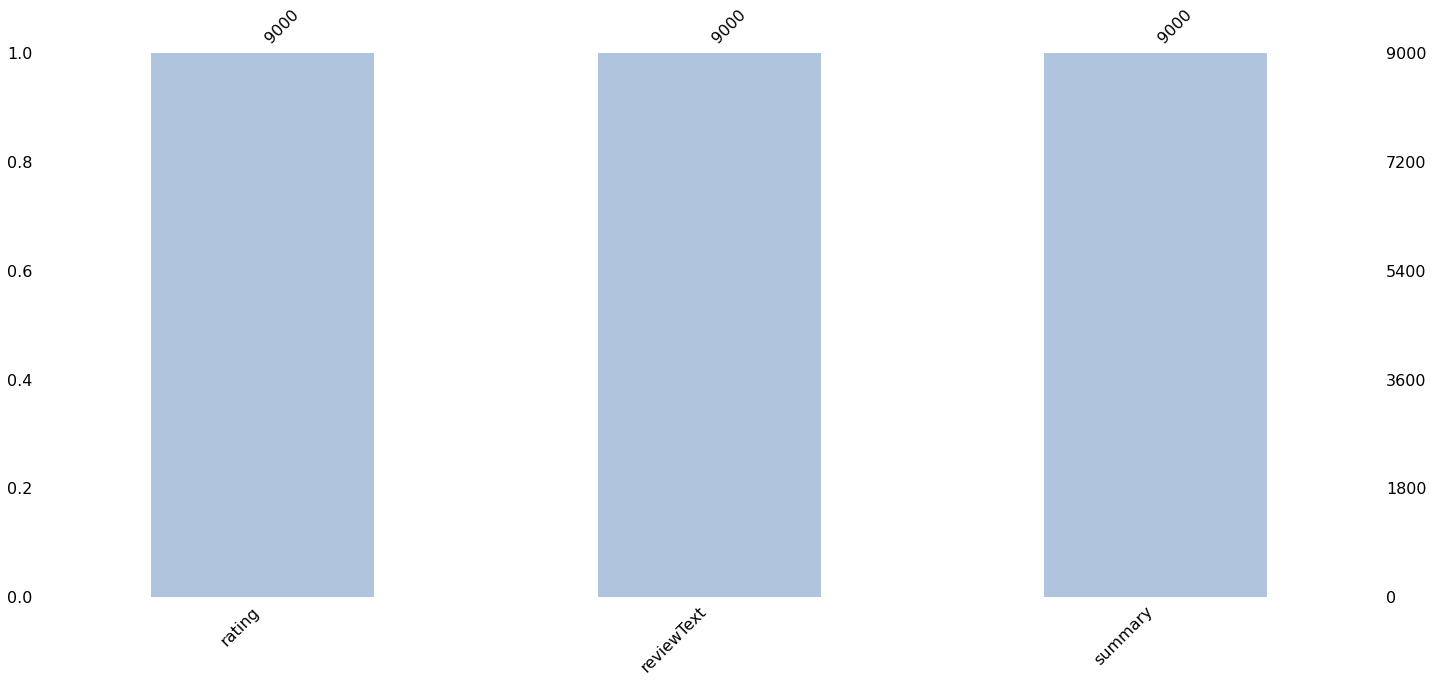

In [5]:
# missing value
msn.bar(dataset, color='lightsteelblue')

no missing value

### 2.2. Target

<AxesSubplot:xlabel='rating', ylabel='Count'>

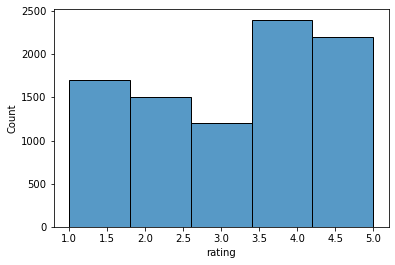

In [6]:
sns.histplot(data = dataset, x = "rating", bins = 5)

Several conclusions:
- This is a multi-classfication problem.
- Classes have order - Ordinal classification.
- The target is slightly umbalanced, 4 and 5 has more examples and 3 has less examples.

### 2.3 Text Features 

<AxesSubplot:xlabel='reviewTextCharCount', ylabel='Count'>

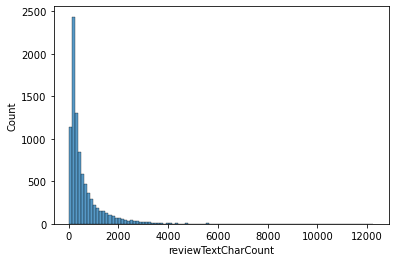

In [7]:
# reviewText
dataset['reviewTextCharCount'] = dataset['reviewText'].apply(len)
sns.histplot(dataset['reviewTextCharCount'], bins = 100)

There are some reviews that writes a really long article while some are just a few words.

Apparently right skewed.

<AxesSubplot:xlabel='summaryCharCount', ylabel='Count'>

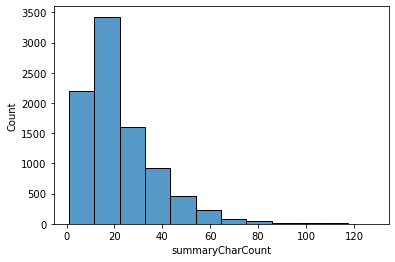

In [8]:
# summary
dataset['summaryCharCount'] = dataset['summary'].apply(len)
sns.histplot(dataset['summaryCharCount'], bins = 12)

`summary` has much shorter length but it is also right skewed.

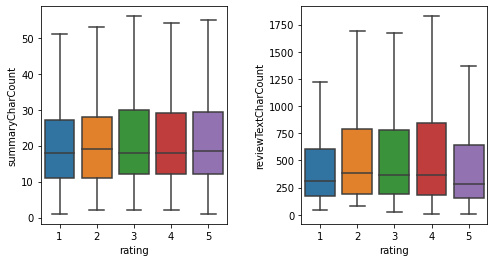

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8,4))
sns.boxplot(x = 'rating',y='summaryCharCount', data = dataset, showfliers = False, ax= ax1)
sns.boxplot(x = 'rating',y='reviewTextCharCount', data = dataset, showfliers = False, ax = ax2)
plt.subplots_adjust(wspace=0.4)
plt.show()

As is shown in the boxplot(outlier excluded), there is little difference in the length of reviews and summaries between different ratings.

Review text length will be less on rating 1 and 5, with other ratings have longer text, the difference is small though.

So merely the length of the text will not be a good indicator of rating.

### 2.4. Between `reviewText` and `summary`


In [10]:
# define the overlap similarity score
# we use overlap instead of other methods 
# because the difference in length between two columns are quite big
def overlapSim(str1, str2):
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / min(len(a),len(b))

overlapScoreResult = []
for i,row in dataset.iterrows():
    s1 = row.reviewText
    s2 = row.summary
    overlapScore = overlapSim(s1, s2)
    overlapScoreResult.append(overlapScore)

dataset.insert(loc = 4,
              column = 'overlapScore',
              value = overlapScoreResult)

<AxesSubplot:xlabel='overlapScore', ylabel='Count'>

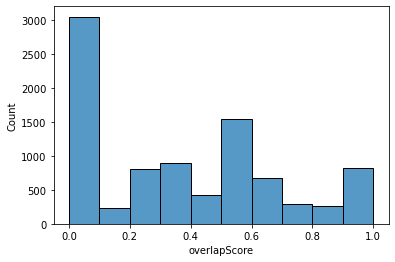

In [11]:
sns.histplot(dataset['overlapScore'],bins = 10)

<AxesSubplot:xlabel='rating', ylabel='overlapScore'>

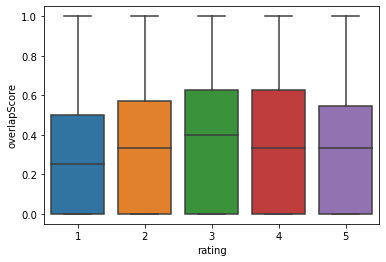

In [12]:
sns.boxplot(x = 'rating',y='overlapScore', data = dataset)

There is a large proportion of reviews that its summary has no **word similarity** with its content.

However, this does not necessarily mean they do not have **semantic similarity**, more advanced techniques(using trained model / vectorized representation / after normalization) can be used to analyse the sementical similarity.

The reason why similarity is analysed here is that `summary` may not provide accurate attitude and will be elaborate on the longer `reviewText`.

## 3. Data Preprocessing
We now have only the text data, which should be transformed into numerical representation to feed the model as computer can only handle structured data. 

Before that, texts should be normalized to reduce the variation:

Example:

`'good', 'GOOD', 'Goooood', 'best', 'great', 'graet', 'good!'` should mean the same thing with only slight difference in terms of **form, puntuation, upper/lower case, typo, etc.**. But the model may consider them as different word if only simple methods is used to transform them.

For better generalization. Steps including:
- lower case
- contraction expansion
- stop word removal
- punctuation removal
- lemmatization and stemming
- part of speech tagging
- ...

**NOTE** that data quality is the most important thing - GARBAGE IN, GARBAGE OUT - The normalization steps should not have too much information loss.

There are many methods to tranform the texts into numbers:
1. Bag of words
2. TF-idf
3. Advanced embedding method (vectorization)

**Note that some methods may cause data leakage** - methods that involve information in the test/validation set. - We should retrict these methods to be deployed in the training set only.

In [13]:
# convert html entities
# &#8217; => '

def htmlEntityTran(DF, columns):
    for acol in columns:
        DF[acol] = DF[acol].apply(lambda x: html.unescape(x))

In [14]:
# expand contractions such as 
# I'm -> I am

def contractionExpansion(DF, columns):
    for acol in columns:
        DF[acol] = DF[acol].apply(lambda x: contractions.fix(x))

In [15]:
def punctuationProcess(DF, columns):
    for acol in columns:
        DF[acol] = DF[acol].apply(lambda x: puncFix(x))
        
smileEmo = r""":-) :) :-] :] :-> :> 8-) 8) :-} :} :o) :c) :^) =] =) ^_^ ^^ :') :3 :-3 =3 x3 X3 (: (-: ))""".split(" ") 

laughEmo =  r""":-D :D 8-D 8D =D =3 B^D c: x-D xD X-D XD C:]""".split(" ")

winkEmo = r""";-) ;) *-) *) ;-] ;] ;^) ;> :-, ;D ;3""".split(" ")

sadEmo = r""":-( :( :-c :c :-< :< :-[ :[ :-|| >:[ :{ :@ :( ;( :'-( :'( :=( :$ ): """.split(" ")

skepEmo =r"""
:-/ 
:/ 
:-. 
>:\
>:/
=/
=\
:L
=L
:S
:-|
:|
-_-
""".split()
           
stunEmo = r""":-O :O :-o :o :-0 8‑0 >:O =O =o =0 O_O o_o O-O o-o O_o o_O""".split(" ")

def puncFix(row):
    for emoticon in smileEmo:        
        row = row.replace(emoticon, 'smileface')
    for emoticon in laughEmo:        
        row = row.replace(emoticon, 'laughface')
    for emoticon in winkEmo:        
        row = row.replace(emoticon, 'winkface')
    for emoticon in sadEmo:        
        row = row.replace(emoticon, 'sadface')
    for emoticon in skepEmo:        
        row = row.replace(emoticon, 'skepticalface')
    for emoticon in stunEmo:        
        row = row.replace(emoticon, 'stunnedface')

    row = row.replace('$$','ss')
    row = row.replace('$','money')
    row = row.replace('w/','with')
    row = re.sub(r"""(?<=[,.!'";:()*?/-])(?=[a-zA-Z])""", ' ', row)
    row = re.sub(r"""(?<=[a-zA-Z])(?=[,.!'";:()*?/-])""", ' ', row)
    row = re.sub(r"[...][.]+", '...', row)
    row = re.sub(r"[--][-]+", '--', row)
    row : row.replace('**', ' ** ')
    return row


In [16]:
# lower case
# A => a
def lowercaseCountTranformer(DF, columns):
    """
    This function transform all the characters into lower case,
    And store the number of upper case
    """
    for acol in columns:
        DF[acol+'UpperCount'] = DF[acol].apply(lambda x: sum(1 for c in x if c.isupper() ) )
        DF[acol] = DF[acol].apply(lambda x: x.lower())

In [17]:
# lemmatization and stemming
# turn the word back to its original form

# tokenization
# turning a sentense into a list of words

def LemmatizationTransform(DF, columns, mode = "Lemma"):
    """
    spacy is used but only the tokenization and lemmatization pipeline component is implemented on the data.
    NLTK has some similar function but lack the precision 
    
    Example:
    'lemmatizing'
    in nltk -> lemmatiz
    in spacy -> lemmatize
    
    tokenization is also done by this step together in SpaCy
    """
    for acol in columns:
        if mode == "Lemma":
            DF[acol+'tokenized'] = DF[acol].apply(lambda row: [token.lemma_ for token in spacyNLP(row)])
        else:
            DF[acol+'tokenized'] = DF[acol].apply(lambda row: [token.text for token in spacyNLP(row)])

In [18]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
origin = set(stopwords.words('english'))

wanted = {'what','but','against','down','up','on','off','over','under','out','same'
                'again','further','why','what','how', 'all', 'any','with'
                'few', 'more', 'most', 'other','no', 'nor', 'not', 'only',
                'than', 'too', 'very', 'just', 'should', 'ain',
                'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
                "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
                'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}

unwanted = {'the','I',"'s"}

StopWordCustom_Deep = list(origin - wanted | unwanted)

StopWordCustom_Shallow = ["it's", 'their', 're', 'she', 'ours', 
                          'it', 've', 'you', 'y', 'o', 'themselves',
                          'your', 'yours', 'm', "you'd",
                          "you're", 'and', 'its', "you've", 'that', 'ourselves',
                          'himself', 'this', 'been', "you'll", 'an', 'my', 'me',
                          'myself', 'a', 'these', 'which',
                          'he', 'his', 'I', 'them', 'the', "'s", 'yourselves', 
                          'our', 's', 'yourself', 'theirs', 'herself', 'they', "she's",
                          'hers', 'we', 'those', 'him', "that'll", 'i', 'her', 'itself']
# stopword removal
def stopWordRemove(DF, columns, deep = True):
    for acol in columns:
        if deep == True:
            DF[acol] = DF[acol].apply(lambda alist: [item for item in alist if item not in StopWordCustom_Deep])
        else:
            DF[acol] = DF[acol].apply(lambda alist: [item for item in alist if item not in StopWordCustom_Shallow])


In [20]:
# punctuation
# '...' and '!' and '?' would contain some information about the sentiment

punctList = set(string.punctuation)
puncwanted = {'!', '?'}
puncunwanted = {' '}
punctList = punctList - puncwanted | puncunwanted 

def punctRemover(DF, columns):
    for acol in columns:
        DF[acol] = DF[acol].apply(lambda alist: [item for item in alist if item not in punctList])
        

In [21]:
punctuationException = {'?','!','...'}
others = {'eh'}
symspellException = punctuationException | others

In [22]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def spellcheck(tokens):
    checkedtokens = []
    for token in tokens:
        if (token not in symspellException) and (not token.isnumeric()):
            try:
                checkedtokens.append(sym_spell.lookup(token, Verbosity.CLOSEST, max_edit_distance=2)[0].term)
            except:
                checkedtokens.append(token)
        else:
            checkedtokens.append(token)
    return checkedtokens

def spellCheckReplace(DF, columns):
    for acol in columns:
        DF[acol] = DF[acol].apply(spellcheck)

- The html entity code for special characteristics: **(solved)**

iloc[2941] - `&#34;`

iloc[7085] - `&eacute;`

- Some emoji/ simple face expression **(solved)**

> spaCy have the ability in tokenizing the text-based emoticon
https://github.com/explosion/spaCy/blob/master/spacy/lang/tokenizer_exceptions.py#L115

iloc[3697] - `:)`

iloc[8983] - `;-)`

- repeated punctuation (not solved)

iloc[2998] - `WHAT?!?!?!?!`

iloc[7486] - `...`

- Abbreviation (not solved)

iloc[5884] - `def.` == `definitely`

iloc[8503] summ. - `$` == money

iloc[8163] summ. `w/` == with

- Direct information (not solved)

iloc[4695] - `**4.5 stars**`

- Wierd expressions (not solved)

iloc[2873] - `a$$`

- Typo **solved**

iloc[4026] summ. - `lovrd it`

- `spacy` tokenization problems **solved**

iloc[4695] - `**4.5 stars**` ==> `stars**i`

More can be done
- phrase extraction
    - by adding exceptions in tokenization
- expansion with synonyms
    - augmentation
- dependence parsing

- sentense tokenization

Possibility in improvements in normalization and tokenization:
- **lower case**, some people may use all upper case to express a strong feeling and that may be a good indicator of an extreme rating.
- **punctuation**, some punctuation,  `!` - implies a strong expression, `?` implies a questioning attitude, `...` implies skeptical or reserved feelings - decided by context. And some more advanced expressions like `:)`,`:P`, could also contain some sementic meanings but is excluded in the analysis.
- **stop words**, we may add more stop words other than common one(which should be task-specific) this could be done by looking at the prediction faeture importance using `SHAP` library.
- **abbreviation&slang**, there are some abbreviation or slang that can be extended to its original form that can be further normalize the dataset.
These aspects can shed light on the model performance improvement.

In [23]:
# Workflow of deep preprocess
def DeepPreprocess(df):
    htmlEntityTran(df,['reviewText','summary']) # &#34; => "
    contractionExpansion(df,['reviewText','summary']) # I'm => I am
    punctuationProcess(df,['reviewText','summary']) # add space before puncs; emoticon; normalize
    lowercaseCountTranformer(df, ['reviewText','summary']) # A => a ; add count column
    LemmatizationTransform(df,['reviewText','summary']) # smiled => smile; tokenized
    stopWordRemove(df,['reviewTexttokenized','summarytokenized']) # delete "I"
    punctRemover(df,['reviewTexttokenized','summarytokenized']) # delete meaningless punctuation
    spellCheckReplace(df,['reviewTexttokenized','summarytokenized']) # graet => great
    
DeepPreprocess(dataset)

In [24]:
#DeepPreprocess(dataset)
#subData = pd.read_csv('test.csv')
#DeepPreprocess(subData)
#subData.to_csv('preprocessedtest_deep.csv')
#dataset.to_csv('preprocessedtrain_deep.csv')

In [26]:
# shallow preprocessing (for neural networks that can learn grammar)
def ShallowPreprocess(df):
    htmlEntityTran(df,['reviewText','summary']) # &#34; => "
    contractionExpansion(df,['reviewText','summary']) # I'm => I am
    punctuationProcess(df,['reviewText','summary']) # add space before puncs; emoticon; normalize
    lowercaseCountTranformer(df, ['reviewText','summary']) # A => a ; add count column
    LemmatizationTransform(df,['reviewText','summary'], mode = "shallow") # only tokenized
    stopWordRemove(df,['reviewTexttokenized','summarytokenized'], deep = False) # delete "I"
    punctRemover(df,['reviewTexttokenized','summarytokenized']) # delete meaningless punctuation
    


In [27]:
# run this to do shallow preprocess 
# keep the proposition 
# avoid using misspelling correction - 
# it may do wrongly and convert useful information to something else

#subData = pd.read_csv('test.csv')
#ShallowPreprocess(dataset)
#ShallowPreprocess(subData)

subData.to_csv('preprocessedtest_deep.csv')
dataset.to_csv('preprocessedtrain_deep.csv')

## Data quality checker

In [28]:
# data quality checker
a = random.randint(0,9000)
a = 8983
print(a)
print(dataset['reviewTexttokenized'].iloc[a])
print("==============================")
print(dataset['summarytokenized'].iloc[a])
print("==============================")
print(dataset['reviewText'].iloc[a])
print("==============================")
print(dataset['summary'].iloc[a])
print("******************************")
print(originData['reviewText'].iloc[a])
print("==============================")
print(originData['summary'].iloc[a])

8983
['just', 'discovered', 'author', 'is', 'wonderful', 'there', 'is', 'some', 'nascar', 'with', 'feisty', 'female', 'driver', 'really', 'hot', 'dom', 'acting', 'as', 'protector', 'among', 'other', 'things', 'winkfacei', 'really', 'enjoyed', 'well', 'written', 'novella', 'only', 'complaint', 'was', 'ended', 'too', 'soon']
['what', 'is', 'not', 'to', 'love', '?']
i just discovered this author and she is wonderful . there is some nascar with a feisty female driver and a really hot dom acting as her protector ( among other things ) winkfacei really enjoyed this well - written novella . my only complaint was that it ended too soon .
what is not to love ?
******************************
I just discovered this author and she is wonderful. There's some NASCAR with a feisty female driver and a really hot Dom acting as her protector (among other things) ;-)I really enjoyed this well-written novella. My only complaint was that it ended too soon.
What's Not To Love?


In [29]:
from collections import Counter
counter = Counter()

MaxLengthReview = 0
MaxLengthSummary = 0

for row in dataset['reviewTexttokenized']:
    counter.update(row)
    if len(row) > MaxLengthReview:
        MaxLengthReview = len(row)

for row in dataset['summarytokenized']:
    counter.update(row)
    if len(row) > MaxLengthSummary:
        MaxLengthSummary = len(row)
        
print('MaxLengthReview', MaxLengthReview)
print('MaxLengthSummary',MaxLengthSummary)

MaxLengthReview 1746
MaxLengthSummary 20


In [30]:
for akey in sorted(counter.keys()):
    for char in akey:
        a = 0
        if char in string.punctuation:
            a = a + 1
    if a > 0:
#        if counter[akey]>=2:
        print(akey, '|===>', counter[akey]) 

! |===> 6249
'' |===> 1
): |===> 21
-')= |===> 1
-- |===> 617
-10- |===> 1
-à- |===> 1
."- |===> 5
.)- |===> 1
.- |===> 137
.-- |===> 8
... |===> 3238
./ |===> 1
.0- |===> 1
.99- |===> 1
.[ |===> 1
.~ |===> 1
.~~ |===> 1
0/ |===> 5
1)- |===> 25
1- |===> 15
1.- |===> 2
10- |===> 3
100- |===> 1
11- |===> 1
12- |===> 2
120- |===> 1
13- |===> 1
14- |===> 3
15- |===> 2
16- |===> 1
18- |===> 2
2)- |===> 1
2- |===> 5
20- |===> 5
200- |===> 1
26- |===> 1
28- |===> 1
29- |===> 1
3)- |===> 1
3- |===> 9
3.- |===> 1
3.5</ |===> 1
30- |===> 3
300- |===> 1
36)-- |===> 1
4- |===> 8
40- |===> 3
4;-- |===> 1
5- |===> 8
50+% |===> 1
50- |===> 2
54- |===> 1
6- |===> 3
60+% |===> 1
60- |===> 9
7- |===> 2
8- |===> 1
80- |===> 1
:* |===> 12
:-* |===> 1
=( |===> 2
? |===> 2719
a+ |===> 7
a++ |===> 1
a+++++ |===> 1
b+ |===> 2
book[ |===> 1
book~ |===> 1
bright= |===> 1
c+ |===> 3
call</ |===> 1
cliché- |===> 1
excellent@ |===> 1
f#&@ |===> 1
href= |===> 1
ink</ |===> 1
jo~ |===> 1
long~ |===> 1
mc~ |===> 1
mo